# Building a simply biosphere C cycle model
Prepared by Ana Bastos (abastos@bgc-jena.mpg.de) for the ICOS summer school 2024. 

## Motivation
In this course, we will build a simple box model for the global terrestrial biosphere CO<sub>2</sub> cycling, based on Emanuel et al. in Bolin et al. (1981, SCOPE-16). Several types of box models for the representation of the terrestrial biopshere have been proposed. The simplest models include only two pools to reflect live vs. dead or fast vs. slow pools to reflect the different residence times of carbon in the terrestrial biosphere (e.g. Bolin, 1970 or Keeling 1973). 

To include finer detail about the transfers of carbon within the biosphere and better reflect structural components of ecosystems, more compartments can be added. 
The model in Emanuel et al. (1981) consists of five compartments representing different carbon pools in vegetation (woody and non-woody types), litter and soils. Each compartment is considered well-mixed and the compartments are connected by fluxes of carbon, as described by the figure below.  

<img src="TerrestrialBiopshereModel.png">

The first pool is the atmosphere, which is the source of CO<sub>2</sub> into the biosphere (1). Carbon is taken up by the biosphere through leaf photosynthesis (green arrows) into the non-woody pools in trees (pool 2) and grasses/crops (pool 4), where some of it is respired back to the atmosphere. Non-woody pools include leaves, flowers, fruits and fine roots. In trees, part of the carbon is then allocated to wood production, represented here by a flux from the non-woody (pool 2) to the woody pool in trees (pool 3). Growth and maintenance respiration of woody parts results in a flux of carbon from the woody pool to the atmosphere (red arrows). Carbon in non-woody pools and a fraction of carbon in tree woody pools is later transferred to the litter layer on the soil surface (pool 5). There, a fraction of carbon is emitted back to the atmosphere through heterotrophic respiration, while another fraction is transfered to the soil (active soil C pool, 6). Death of vegetation and decomposition of below ground biomass further contribute to fluxes to the active soil C pool (from pools 3 and 4). Finally, part of the carbon in the active soil layer is decomposed and emitted back to the atmosphere.  

The numbers in brown indicate an estimate of carbon in C pools (in GtonC) and the fluxes (in GtonC/yr) between pools for steady-state conditions, given by Emanuel et al. 

### Conceptual description of the model 
First, we will consider that the biosphere is in steady-state, as would be approximately the case under no human influence through climate and elevated CO<sub>2</sub> and at longer time scales. The carbon stocks in each individual pool (i) are given by N<sub>i</sub> and the fluxes between two pools (i and j) are represented by F<sub>ij</sub>. 
The fluxes between each comparment are assumed to be proportional to the content of the compartment, so that: 

$F_{ij} = k_{ij}N_{i}$

In that case, we can write a system of equations representing the exchanges of carbon between the six pools (five biospheric and the atmosphere):

$dN_2/dt = F_{12} - (k_{21}+k_{23}+ k_{25})N_{2} $  

$dN_3/dt = k_{23}N_{2} - (k_{31}+k_{35}+ k_{36})N_{3} $ 

$dN_4/dt = F_{14} - (k_{41}+k_{45}+ k_{46})N_{4} $ 

$dN_5/dt = k_{25}N_{2} + k_{35}N_{3} + k_{45}N_{4} - (k_{51}+k_{56})N_{5} $ 

$dN_6/dt =  k_{36}N_{3} + k_{46}N_{4} + k_{56}N_{5} - k_{61}N_{6} $ 




We values of N<sub>i</sub> in steady state conditions are indicated by N<sub>i0</sub>.

## Building the model and applying it to an idealized test-case
We will first set up the code that will allow us to solve the system of ODEs above. We will do this in python. You can use a Jupyter Notebook, Spyder or your prefered IDE. The material for this course will be made available in a Jupyter Notebook, but for the course, it is recommended that you try to follow the steps autonomously. 

In [1]:
### First, load packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline


The values of N<sub>i0</sub> are based on Emanuel et al, except N<sub>10</sub> which is taken from the Law Dome ice-core CO<sub>2</sub> record in the year 1860 (beginning of the industrial period): 607.2843 GtonC. This value will be used also later on. 

In [2]:
### We can define an array with the steady-state values of the different pools and fluxes:
# in order N1, N2, N3, N4, N5, N6
N10 = 607.2843
N20 = 37.
N30 = 452.
N40 = 69.
N50 = 81.
N60 = 1121.

# fluxes defined in Emanuel et al.
F12 = 77.
F14 = 36.
F21 = 25.
F23 = 31.
F25 = 21. 
F31 = 14.
F35 = 15.
F36 = 2.
F41 = 18.
F45 = 12.
F46 = 6.
F51 = 45.
F56 = 3. 
F61 = 11.


### Then we define the turnover coefficients, based on the steady-state conditions
# Fluxes from pool 1.
k12  = F12/N10
k14  = F14/N10
# Fluxes from pool 2.
k21  = F21/N20
k23  = F23/N20
k25  = F25/N20
# Fluxes from pool 3.
k31  = F31/N30
k35  = F35/N30
k36  = F36/N30
# Fluxes from pool 4.
k41  = F41/N40
k45  = F45/N40
k46  = F46/N40
# Fluxes from pool 5.
k51  = F51/N50
k56  = F56/N50
# Fluxes from pool 6.
k61  = F61/N60


We will solve the system system of equations $dN_{i}/dt$ using the Euler method for a period of 200 years. We will impose a perturbation  of 5GtonC to the steady-state fluxes in the second decade of the time period, and evaluate how carbon is redistributed through the different pools. 

Python has an inbuilt differential equation integration solver that makes it very straightforward to apply the Runge-Kutta of 4th order (default) or other advanced integration methods (solve_ivp). 

First, we build a function for the system of equations above that can be given as input to the solver function. 

In [3]:
### We first define the function. 
# The first two inputs are time and the vector of the state variables we want to calculate.
# The other inputs correspond to the turnover parameters. 

def deltaCarbon6box(t, N,k12,k14,k21,k23,k25, k31,k35,k36,k41,k45,k46,k51,k56,k61): 
    
    # For the solver to work properly, we now need to convert the photosynthesis fluxes into a
    # function that takes (t) as input. This function for a photosynthesis pulse is defined below.
    F12_t, F14_t = photosynthesis_pulse(t)

    dN2dt =    F12_t   - (k21+k23+k25)*N[0] ## Changes in N2
    dN3dt = k23*N[0] - (k31+k35+k36)*N[1] ## Changes in N3
    dN4dt =    F14_t   - (k41+k45+k46)*N[2] ## Changes in N4
    dN5dt = k25*N[0] + k35*N[1] + k45*N[2] - (k51+k56)*N[3] ## Changes in N5
    dN6dt = k36*N[1] + k46*N[2] + k56*N[3] -  (k61)*N[4] ## Changes in N6
    return dN2dt,dN3dt,dN4dt,dN5dt,dN6dt        

def photosynthesis_pulse(t):
    F12_t         = F12 
    F14_t         = F14 
    if (t>=10) & (t<20):   
        F12_t     += 5
        F14_t     += 5
    return F12_t, F14_t 

Then, we need to define the time domain in which we want to solve the ODE system. Let's consider the interval of 200 years, and use a time-step of 0.1 years. 

Analyse the results:

- How is the flat perturbation expressed in the different pools?
- How long do the different pools take to recover from the perturbation? 
- How does this depend on the perturbation intensity? (change the magnitude of the perturbation intensity, and analyse the results)

Text(0, 0.5, '$\\Delta C$ (GtonC)')

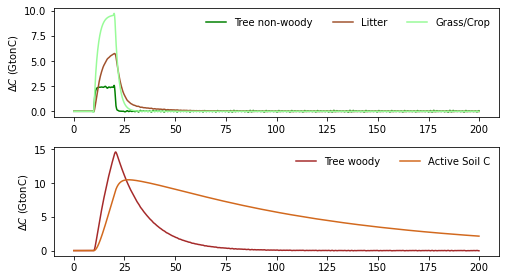

In [4]:
# Define time array
dt       = .1 # time step
time     = np.arange(0,200,dt) 
    
    
# We then need to define the vectors for the pools N. We initialize all time-steps with Ni0. 
# These will be updated in a loop next.
N2       = N20 * np.ones(len(time));
N3       = N30 * np.ones(len(time));
N4       = N40 * np.ones(len(time));
N5       = N50 * np.ones(len(time));
N6       = N60 * np.ones(len(time));
    
# Call the ODE solver. The order of inputs is: 
# function to be integrated, time boundaries of the calculation, initial conditions, additional arguments, time-steps to be evaluated
sol_6box  = solve_ivp(deltaCarbon6box,[time[0],time[-1]],[N20,N30,N40,N50,N60],args = (k12,k14,k21,k23,k25, k31,k35,k36,k41,k45,k46,k51,k56,k61),t_eval=time)

# Let's plot the results again as before. 
plt.figure('Pools - ODE solver',tight_layout=True, figsize=(7,4))
plt.subplot(211)
plt.plot(time,sol_6box.y[0]-N2[0] ,'g',ls='-',label='Tree non-woody')
plt.plot(time,sol_6box.y[3]-N5[0] ,'sienna',ls='-',label='Litter')
plt.plot(time,sol_6box.y[2]-N4[0] ,'palegreen',ls='-',label='Grass/Crop')
plt.legend(loc=1,frameon=False,ncol=3)
plt.ylabel('$\Delta C$ (GtonC)')

plt.subplot(212)
plt.plot(time,sol_6box.y[1]-N3[0] ,'brown',ls='-',label='Tree woody')
plt.plot(time,sol_6box.y[4]-N6[0] ,'chocolate',ls='-',label='Active Soil C')
plt.legend(loc=1,frameon=False,ncol=3)
plt.ylabel('$\Delta C$ (GtonC)')

## Applying the model with atmospheric CO<sub>2</sub> forcing

### Rationale
We saw that the model is able to simulate the redistribution of carbon pulses through the different pools in vegetation, litter and soils. Above, we considered an idealized scenario with constant atmospheric CO<sub>2</sub> concentration. This is not the case in the past centuries, since anthropogenic emissions of fossil fuel emissions (and deforestation, but we will not consider it here) have been increasing the concentration of CO<sub>2</sub> in the atmosphere [CO<sub>2</sub>]. The two systems are coupled, but here we will focus only on the impact of rising CO<sub>2</sub> concentration on biospheric carbon pools. An extension of this model is possible by adding ocean pools, but is beyond of the scope of this course. 

 Instead of the approximation proposed by Emanuel et al., we will use directly observations of [CO<sub>2</sub>] since 1959 from the Global Carbon Budget (Friedlingstein et al. 2021), extended back to 1860 based on ice-core data from the Law dome record (Etheridge et al. 1996). The merged data are organised in a .csv file "CO2_LawDome_MLO.csv". 

Let's read in the data and plot the atmospheric CO<sub>2</sub> data. 


Text(0, 0.5, 'Atmospheric CO$_2$ (GtonC)')

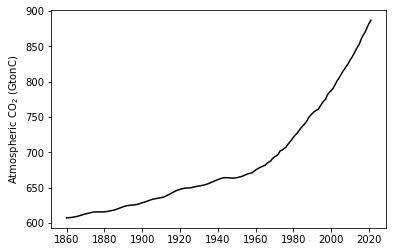

In [17]:
### Load csv file
# Values are already in GtonC (ppm*2.13) (https://cdiac.ess-dive.lbl.gov/pns/convert.html#2.)
atm      = pd.read_csv('CO2_LawDome_GCP.csv', sep=',',index_col=[0]).CO2

plt.figure()
plt.plot(atm,color='k',label='Observed CO2')
plt.ylabel('Atmospheric CO$_2$ (GtonC)')

### Enhancement of Photosynthesis by elevated [CO<sub>2</sub>]
Assimilation of CO<sub>2</sub> in the stomata depends on the concentration of CO<sub>2</sub> in the atmosphere. In global carbon cycle modelling, the stimulation of photosynthesis by CO<sub>2</sub> has been called ‘CO<sub>2</sub> fertilization’ (e.g. Bacastow & Keeling, 1973). Whether the increase of assimilated carbon results in growth and net carbon storage or not depends on several other limiting factors, for example nutrients and water availability. For simplicity, we will ignore such limiting factors here, but refer to Walker et al. (2021) for a review on the topic. 

The enhancement of photosynthesis by atmopsheric CO<sub>2</sub> can be represented by a logarithmic function that increases with increasing [CO<sub>2</sub>] relative to a baseline value. In our model, we will thus update the two photosynthesis fluxes $F_{12}$ and $F_{14}$:

$F_{12} = k_{12}\times(1 + \beta_{12} \times ln(N_{1}/N_{10})) \times N_{2}$ 

$F_{14} = k_{14}\times(1 + \beta_{14} \times ln(N_{1}/N_{10})) \times N_{4}$

We need to update the photosynthesis and box model functions:

In [6]:
###### Define new photosynthesis function

def photosynthesis(n2,n4,N1,N10):
    F12_t = k12 * (1 + beta_12 * np.log(N1/N10) ) * n2
    F14_t = k14 * (1 + beta_14 * np.log(N1/N10) ) * n4
    return F12_t, F14_t


# We adapt the 6 box model function to include now beta_12 and beta_14, as well as N1 (atm CO2) as additional input arguments
def deltaCarbon6box(t, y,k12,k14,k21,k23,k25, k31,k35,k36,k41,k45,k46,k51,k56,k61, beta_12, beta_14, N1): 
    
    F12_t, F14_t = photosynthesis(y[0],y[2],N1(t),N1(1860)) ### define atm CO2 in 1860 as baseline

    dN2dt =    F12_t   - (k21+k23+k25) * y[0] ## Changes in N2
    dN3dt = k23 * y[0] - (k31+k35+k36) * y[1] ## Changes in N3
    dN4dt =    F14_t   - (k41+k45+k46) * y[2] ## Changes in N4
    dN5dt = k25 * y[0] +   k35 * y[1]  + k45 * y[2] - (k51+k56) * y[3] ## Changes in N5
    dN6dt = k36 * y[1] +   k46 * y[2]  + k56 * y[3] -     (k61) * y[4]
    return dN2dt,dN3dt,dN4dt,dN5dt,dN6dt

    
# For the function to work, we need to write another small function calling N1(t), i.e. the values of atmospheric CO2:
def obs_co2(t):
    t1 = atm.index.values
    n1 = atm.values
    return n1[np.argmin(np.abs(t1-t))]


We then need to define the values of the $\beta$ factors, and define the period over which we want to estimate CO<sub>2</sub> changes. The parameters $k_{12}$ and $k_{14}$ are then dependent on [CO<sub>2</sub>]. These parameters can be approximated at t=0 (in our case, t=0 corresponds to 1860, i.e. beginning of the industrial period), as:

$k_{12} = \frac{F_{12}(t=0)}{N_{2}(t=0)}$;  $k_{14} = \frac{F_{14}(t=0)}{N_{4}(t=0)}$


Emanuel et al. estimate:

$k_{12} = 2.081 yr^{-1}$;  $k_{14} = 0.5217 yr^{-1}$

and:

$\beta_{12} =  0.00525$;   $\beta_{14} = 0.0209$

Solve the system of ODEs with atmospheric [CO<sub>2</sub>] as forcing, considering the full period covered by the data, i.e. 1860-2020. 

The latest GCB2021 estimates that the sum of carbon accumulated in the biosphere from 1850-2020 is 195$\pm$95GtonC (Table 8, in Friedlingstein et al., 2021). 

- Plot the change in carbon in the biopsheric system (adding up the different pools) since the pre-industrial period
- Compare your results with the values of GCB2021. What do you conclude? 



In [7]:
## Need to define beta factors (defined in Emanuel et al.)
beta_12 = 0.00525 
beta_14 = 0.0209  


## The parameters k12 and k14 also need to be updated. 
k12     = 2.081  # Updated based on Emanuel et al.
k14     = 0.5217 # Updated based on Emanuel et al.

time    = np.arange(atm.index[0],atm.index[-1],.5)  ### We want to evaluate the solution in the same time domain as observations 

sol_6box_obs    = solve_ivp(deltaCarbon6box,[time[0],time[-1]],[N20,N30,N40,N50,N60],args = (k12,k14,k21,k23,k25, k31,k35,k36,k41,k45,k46,k51,k56,k61, beta_12, beta_14,obs_co2),t_eval=time)


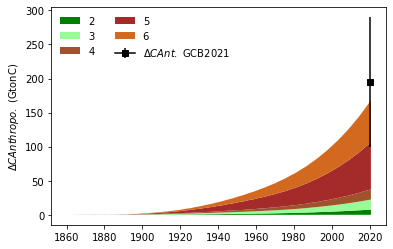

In [14]:
plt.figure('Pools')
plt.errorbar([2020],[195],yerr=[95],color='k',marker='s',label='$\Delta C Ant.$ GCB2021')
plt.stackplot(time,sol_6box_obs.y[0]-N2[0],sol_6box_obs.y[2]-N4[0],sol_6box_obs.y[3]-N5[0],sol_6box_obs.y[1]-N3[0],sol_6box_obs.y[4]-N6[0], colors=['g','palegreen','sienna','brown','chocolate' ],labels=['2','3','4','5','6'])
plt.ylabel('$\Delta C Anthropo. $ (GtonC)')
plt.legend(frameon=False, ncol=2,loc=2)

### Parameter perturbation (extra, if you have time)

The parameters in the model are highly uncertain (we do not really know what the equilibrium pools and fluxes are). In such cases, parameters can be perturbed and predictions compared with observations, to assess the influence of this uncertainty in the model results (and infer the most plausible values for the parameters). See for example  Bacastow and Keeling 1979. 

- Assume an uncertainty of $\pm25\%$ in the $\beta$ factor for terrestrial photosynthesis. Simulate the changes in anthropogenic C in the terrestrial biosphere corresponding to different values of the $\beta$ factor within that uncertainty. 
- Considering the uncertainty of GCB2021, and assuming no other sources of uncertainty (unlikely!), what is the range of uncertainty that you can infer for $\beta$? 
- Calculate the sensitivity of the cumulative C sink in the terrestrial biosphere to $\beta$. 

# References
 Bolin, B. Carbon cycle modelling (SCOPE 16). United States: N. p., (1981). Web.
 https://scope.dge.carnegiescience.edu/SCOPE_16/SCOPE_16.html
 https://www.osti.gov/biblio/6934624
 
 Etheridge, D.M., L.P. Steele, R.L. Langenfelds, R.J. Francey, J.-M. Barnola, and V.I. Morgan. 1996. Natural and anthropogenic changes in atmospheric CO<sub>2</sub> over the last 1000 years from air in Antarctic ice and firn. Journal of Geophysical Research 101:4115-4128.
 
  

Friedlingstein, P., Jones, M. W., O'Sullivan, M., Andrew, R. M., Bakker, D. C. E.,  et al. (2021). Global Carbon Budget 2020, Earth Syst. Sci. Data, 11, 1783–1838, https://doi.org/10.5194/essd-11-1783-2019.

Bacastow, R. B., & Keeling, C. D. (1979). Models to predict future atmospheric CO2 concentrations. In Workshop on the global effects of carbon dioxide from fossil fuels (pp. 72-90). US Department of Energy. https://www.osti.gov/servlets/purl/6385084#page=82

 
Walker, A.P., De Kauwe, M.G., Bastos, A., Belmecheri, S., Georgiou, K., Keeling, R.F., et al. (2021), Integrating the evidence for a terrestrial carbon sink caused by increasing atmospheric CO2. New Phytol, 229: 2413-2445. https://doi.org/10.1111/nph.16866
 
 
 # Data availability
 LawDome data available at https://cdiac.ess-dive.lbl.gov/trends/co2/lawdome.html